# ALIBI - DETECT

In [34]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from menelaus.datasets import make_example_batch_data
from alibi_detect.cd import MMDDriftOnline
import tensorflow as tf
import torch
from sklearn.decomposition import PCA
from alibi_detect.cd import SpotTheDiffDrift
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from alibi_detect.cd import KSDrift
from alibi_detect.cd import CVMDrift

### Dataset Creation

In [3]:
df = make_example_batch_data()

In [4]:
df

,year,a,b,c,d,e,f,g,h,i,j,cat,confidence,drift
0,2007,5036.441154,198.936685,6995.029198,133187.697950,0.402750,-1.339692,90453.457231,8819.761759,5398.861764,1059.835492,2,0.591243,False
1,2007,10773.027107,179.260652,3467.970499,52174.100900,1.019491,-1.145258,72629.507052,10137.233887,7009.344647,1552.888540,2,0.196090,False
2,2007,6173.596856,199.775829,4921.472906,101848.950792,-2.248839,1.903668,54839.516587,9603.709193,10579.518133,856.266082,1,0.504019,False
3,2007,13208.612929,182.222072,9638.632797,92442.165726,-0.045599,1.106212,84447.758390,12511.305427,5618.433039,451.926312,2,0.487307,False
4,2007,2719.272009,213.028454,5501.439179,79155.846985,-1.602719,-1.368130,168769.099013,16034.259622,6214.909756,853.582074,1,0.211284,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,2021,8434.682418,203.931217,8674.083920,104317.953759,-1.588765,-1.313684,165132.657078,284.979440,7065.994173,83.803525,2,0.641595,True
299996,2021,9701.660570,179.925659,8021.128673,63749.091322,0.412063,0.408188,124630.300901,323.602163,10960.392248,96.796410,1,0.467875,True
299997,2021,6928.908424,210.007943,3312.751778,126116.364855,0.113971,2.432577,107318.127090,214.452933,9491.057615,169.644626,2,0.787726,True
299998,2021,6410.255420,205.092167,6914.861179,158221.742954,0.060710,0.928108,71610.603448,570.911317,8577.498702,61.404365,0,0.689538,True


This function returns a dataframe containing synthetic batch data for use with the repo’s examples. The dataframe’s columns are "year", "a", "b", ... "j", "cat", "confidence", "drift".

- year covers 2007-2021, with 20,000 observations each.

- Features "b", "e", "f" are normally distributed.

- Features "a", "c", "d", "g", "h", "i", "j" have a gamma distribution.

- The "cat" feature contains categorical variables ranging from 1-7, sampled with varying probability.

- "confidence" contains values on [0, 0.6] through 2018, then values on [0.4, 1].

Drift occurs as follows:

- Change the mean of column "b" in 2009. Reverts to original distribution in 2010.

- Change the variance of columns "c" and "d" in 2012 by replacing some samples with the mean. Reverts to original distribution in 2013.

- Increase the correlation of columns "e" and "f" in 2015 (0 correlation to 0.5 correlation).

- Change the mean and variance of column "h" in 2019, and maintain this new distribution going forward. Change the range of the “confidence” column going forward.

- Change the mean and variance of column "j" in 2021.

In [5]:
df = df.iloc[:, 1:-3]

In [6]:
df

,a,b,c,d,e,f,g,h,i,j
0,5036.441154,198.936685,6995.029198,133187.697950,0.402750,-1.339692,90453.457231,8819.761759,5398.861764,1059.835492
1,10773.027107,179.260652,3467.970499,52174.100900,1.019491,-1.145258,72629.507052,10137.233887,7009.344647,1552.888540
2,6173.596856,199.775829,4921.472906,101848.950792,-2.248839,1.903668,54839.516587,9603.709193,10579.518133,856.266082
3,13208.612929,182.222072,9638.632797,92442.165726,-0.045599,1.106212,84447.758390,12511.305427,5618.433039,451.926312
4,2719.272009,213.028454,5501.439179,79155.846985,-1.602719,-1.368130,168769.099013,16034.259622,6214.909756,853.582074
...,...,...,...,...,...,...,...,...,...,...
299995,8434.682418,203.931217,8674.083920,104317.953759,-1.588765,-1.313684,165132.657078,284.979440,7065.994173,83.803525
299996,9701.660570,179.925659,8021.128673,63749.091322,0.412063,0.408188,124630.300901,323.602163,10960.392248,96.796410
299997,6928.908424,210.007943,3312.751778,126116.364855,0.113971,2.432577,107318.127090,214.452933,9491.057615,169.644626
299998,6410.255420,205.092167,6914.861179,158221.742954,0.060710,0.928108,71610.603448,570.911317,8577.498702,61.404365


In [7]:
n_ref = 20000
X_ref, X_t0= df[:n_ref], df[n_ref:]

In [8]:
X_t0.iloc[:,9]

20000     1009.445732
20001     1057.183452
20002      817.014084
20003     1297.106711
20004      936.774306
             ...     
299995      83.803525
299996      96.796410
299997     169.644626
299998      61.404365
299999      83.682479
Name: j, Length: 280000, dtype: float64

### K-S test

In [9]:
def batch_generator(data, batch_size):
    for i in range(0, len(data), batch_size):
        yield data[i:i + batch_size]

def plot_drift_detection(years, p_values, feature_name):
    plt.plot(years, p_values)
    plt.axhline(y=0.01, color='y', linestyle='--', label='Threshold')

    for i, p in enumerate(p_values):
        if p < 0.01:
            plt.plot(years[i], p, 'ro')
            plt.text(years[i], p, 'Drift', fontsize=9, verticalalignment='bottom', horizontalalignment='right', color='r')
    
    plt.xlabel('Años')
    plt.ylabel('P_value')
    plt.title(f'Detección de Drift para la característica "{feature_name}"')
    plt.show()


FEATURE  a


No se detectó drift en el año 2008 con un p-valor de [0.4257469]
No se detectó drift en el año 2009 con un p-valor de [0.66651946]
No se detectó drift en el año 2010 con un p-valor de [0.72507364]
No se detectó drift en el año 2011 con un p-valor de [0.3904392]
No se detectó drift en el año 2012 con un p-valor de [0.3701387]
No se detectó drift en el año 2013 con un p-valor de [0.7971708]
No se detectó drift en el año 2014 con un p-valor de [0.2009276]
No se detectó drift en el año 2015 con un p-valor de [0.5992072]
No se detectó drift en el año 2016 con un p-valor de [0.6833545]
No se detectó drift en el año 2017 con un p-valor de [0.62437415]
No se detectó drift en el año 2018 con un p-valor de [0.8936028]
No se detectó drift en el año 2019 con un p-valor de [0.09388587]
No se detectó drift en el año 2020 con un p-valor de [0.8484822]
No se detectó drift en el año 2021 con un p-valor de [0.76577765]


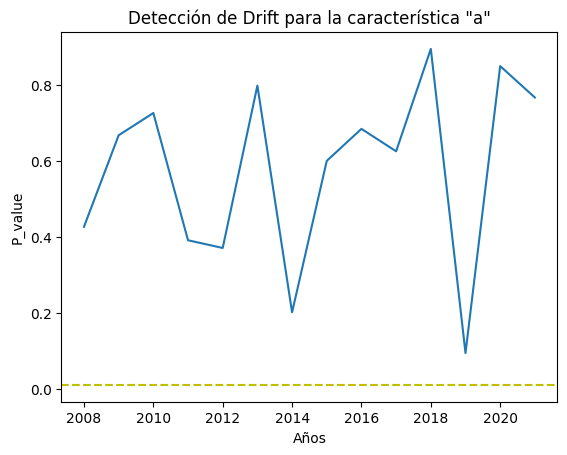

FEATURE  b


No se detectó drift en el año 2008 con un p-valor de [0.46279857]
Drift detectado en el año 2009 con un p-valor de [0.]
No se detectó drift en el año 2010 con un p-valor de [0.28456974]
No se detectó drift en el año 2011 con un p-valor de [0.78944176]
No se detectó drift en el año 2012 con un p-valor de [0.1725747]
No se detectó drift en el año 2013 con un p-valor de [0.7971708]
No se detectó drift en el año 2014 con un p-valor de [0.07484879]
No se detectó drift en el año 2015 con un p-valor de [0.64122146]
No se detectó drift en el año 2016 con un p-valor de [0.46279857]
No se detectó drift en el año 2017 con un p-valor de [0.921145]
No se detectó drift en el año 2018 con un p-valor de [0.7084727]
No se detectó drift en el año 2019 con un p-valor de [0.41854167]
No se detectó drift en el año 2020 con un p-valor de [0.69174975]
No se detectó drift en el año 2021 con un p-valor de [0.2525621]


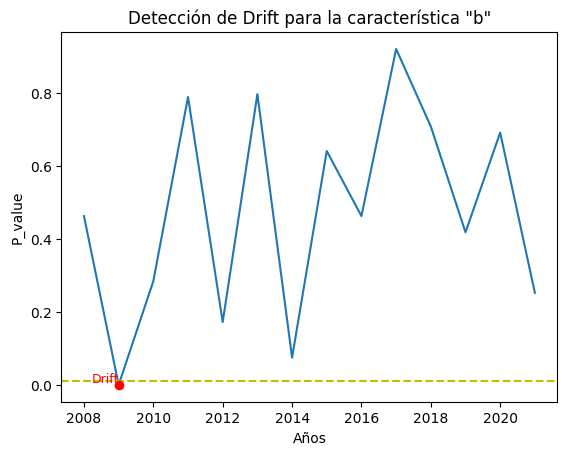

FEATURE  c


No se detectó drift en el año 2008 con un p-valor de [0.7971708]
No se detectó drift en el año 2009 con un p-valor de [0.01144979]
No se detectó drift en el año 2010 con un p-valor de [0.78944176]
No se detectó drift en el año 2011 con un p-valor de [0.17642045]
Drift detectado en el año 2012 con un p-valor de [1.9083079e-23]
No se detectó drift en el año 2013 con un p-valor de [0.7577489]
No se detectó drift en el año 2014 con un p-valor de [0.3904392]
No se detectó drift en el año 2015 con un p-valor de [0.34413663]
No se detectó drift en el año 2016 con un p-valor de [0.21867463]
No se detectó drift en el año 2017 con un p-valor de [0.24250533]
No se detectó drift en el año 2018 con un p-valor de [0.2958586]
No se detectó drift en el año 2019 con un p-valor de [0.78944176]
No se detectó drift en el año 2020 con un p-valor de [0.9106359]
No se detectó drift en el año 2021 con un p-valor de [0.22798434]


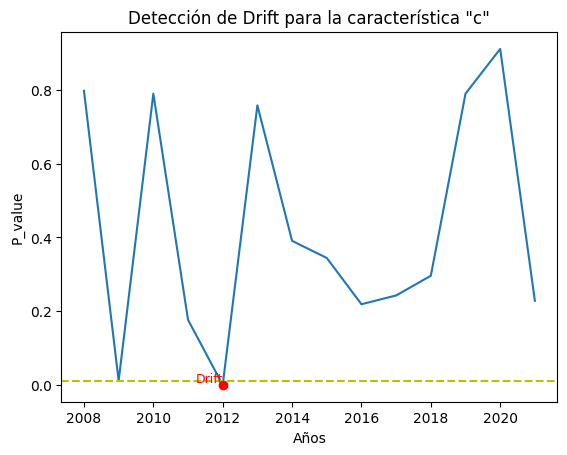

FEATURE  d


No se detectó drift en el año 2008 con un p-valor de [0.72507364]
No se detectó drift en el año 2009 con un p-valor de [0.65808856]
No se detectó drift en el año 2010 con un p-valor de [0.2525621]
No se detectó drift en el año 2011 con un p-valor de [0.8271448]
Drift detectado en el año 2012 con un p-valor de [0.]
No se detectó drift en el año 2013 con un p-valor de [0.8198037]
No se detectó drift en el año 2014 con un p-valor de [0.96903384]
No se detectó drift en el año 2015 con un p-valor de [0.4114074]
No se detectó drift en el año 2016 con un p-valor de [0.21412963]
No se detectó drift en el año 2017 con un p-valor de [0.8484822]
No se detectó drift en el año 2018 con un p-valor de [0.993307]
No se detectó drift en el año 2019 con un p-valor de [0.27904204]
No se detectó drift en el año 2020 con un p-valor de [0.52529234]
No se detectó drift en el año 2021 con un p-valor de [0.7816295]


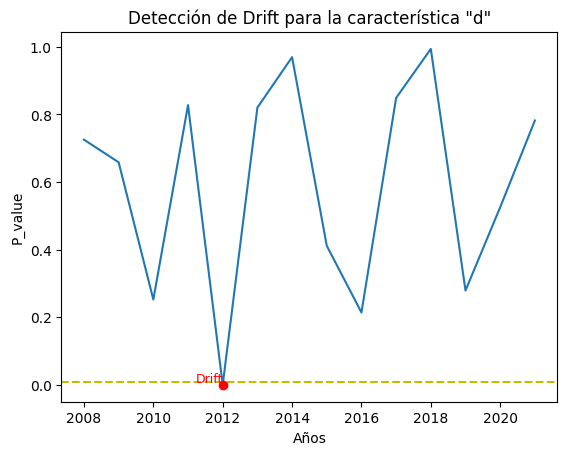

FEATURE  e


No se detectó drift en el año 2008 con un p-valor de [0.85534817]
No se detectó drift en el año 2009 con un p-valor de [0.8343752]
No se detectó drift en el año 2010 con un p-valor de [0.40434504]
No se detectó drift en el año 2011 con un p-valor de [0.24250533]
No se detectó drift en el año 2012 con un p-valor de [0.12540506]
No se detectó drift en el año 2013 con un p-valor de [0.7415128]
No se detectó drift en el año 2014 con un p-valor de [0.8484822]
No se detectó drift en el año 2015 con un p-valor de [0.9718457]
No se detectó drift en el año 2016 con un p-valor de [0.32544708]
No se detectó drift en el año 2017 con un p-valor de [0.7577489]
No se detectó drift en el año 2018 con un p-valor de [0.76577765]
No se detectó drift en el año 2019 con un p-valor de [0.8343752]
No se detectó drift en el año 2020 con un p-valor de [0.5825398]
No se detectó drift en el año 2021 con un p-valor de [0.02870421]


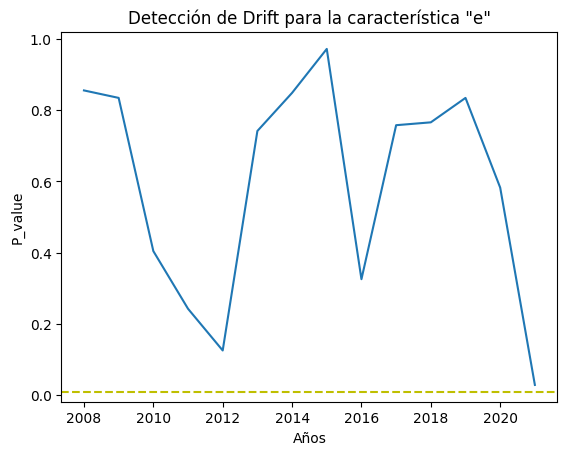

FEATURE  f


No se detectó drift en el año 2008 con un p-valor de [0.13141763]
No se detectó drift en el año 2009 con un p-valor de [0.21867463]
No se detectó drift en el año 2010 con un p-valor de [0.5992072]
No se detectó drift en el año 2011 con un p-valor de [0.8123573]
No se detectó drift en el año 2012 con un p-valor de [0.8271448]
No se detectó drift en el año 2013 con un p-valor de [0.4114074]
No se detectó drift en el año 2014 con un p-valor de [0.4935911]
No se detectó drift en el año 2015 con un p-valor de [0.5414432]
No se detectó drift en el año 2016 con un p-valor de [0.9106359]
No se detectó drift en el año 2017 con un p-valor de [0.7577489]
No se detectó drift en el año 2018 con un p-valor de [0.65808856]
No se detectó drift en el año 2019 con un p-valor de [0.52529234]
No se detectó drift en el año 2020 con un p-valor de [0.36352313]
No se detectó drift en el año 2021 con un p-valor de [0.8048112]


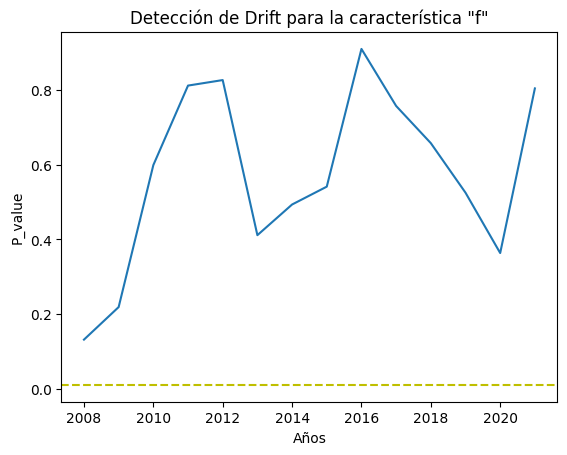

FEATURE  g


No se detectó drift en el año 2008 con un p-valor de [0.5908602]
No se detectó drift en el año 2009 con un p-valor de [0.30162]
No se detectó drift en el año 2010 con un p-valor de [0.3315991]
No se detectó drift en el año 2011 con un p-valor de [0.7496588]
No se detectó drift en el año 2012 con un p-valor de [0.62437415]
No se detectó drift en el año 2013 con un p-valor de [0.78944176]
No se detectó drift en el año 2014 con un p-valor de [0.8876008]
No se detectó drift en el año 2015 con un p-valor de [0.84148943]
No se detectó drift en el año 2016 con un p-valor de [0.47040522]
No se detectó drift en el año 2017 con un p-valor de [0.7577489]
No se detectó drift en el año 2018 con un p-valor de [0.8123573]
No se detectó drift en el año 2019 con un p-valor de [0.7001241]
No se detectó drift en el año 2020 con un p-valor de [0.34413663]
No se detectó drift en el año 2021 con un p-valor de [0.03131193]


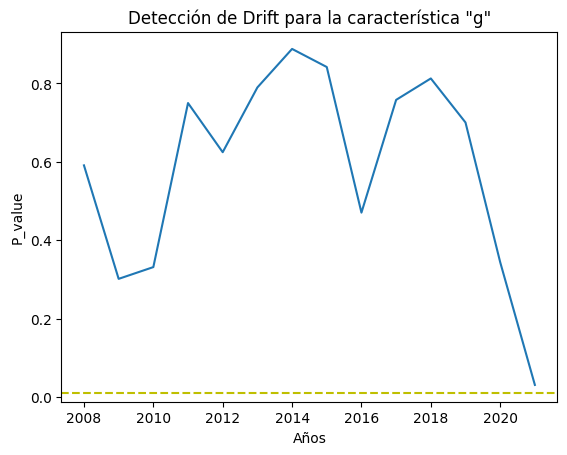

FEATURE  h


No se detectó drift en el año 2008 con un p-valor de [0.5414432]
No se detectó drift en el año 2009 con un p-valor de [0.8936028]
No se detectó drift en el año 2010 con un p-valor de [0.5992072]
No se detectó drift en el año 2011 con un p-valor de [0.8271448]
No se detectó drift en el año 2012 con un p-valor de [0.7001241]
No se detectó drift en el año 2013 con un p-valor de [0.8343752]
No se detectó drift en el año 2014 con un p-valor de [0.76577765]
No se detectó drift en el año 2015 con un p-valor de [0.64122146]
No se detectó drift en el año 2016 con un p-valor de [0.7737397]
No se detectó drift en el año 2017 con un p-valor de [0.7415128]
No se detectó drift en el año 2018 con un p-valor de [0.1843141]
Drift detectado en el año 2019 con un p-valor de [0.]
Drift detectado en el año 2020 con un p-valor de [0.]
Drift detectado en el año 2021 con un p-valor de [0.]


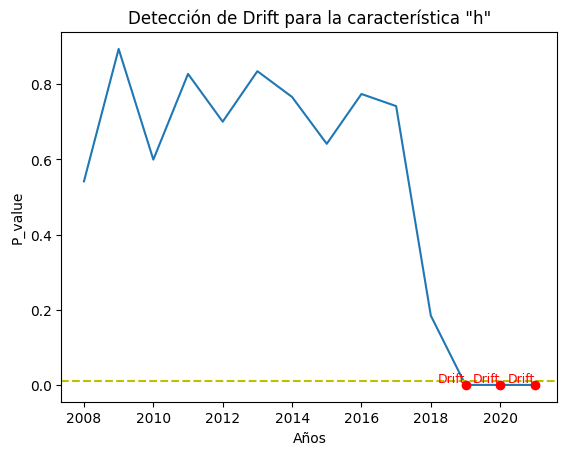

FEATURE  i


No se detectó drift en el año 2008 con un p-valor de [0.7084727]
No se detectó drift en el año 2009 con un p-valor de [0.85534817]
No se detectó drift en el año 2010 con un p-valor de [0.50143594]
No se detectó drift en el año 2011 con un p-valor de [0.7415128]
No se detectó drift en el año 2012 con un p-valor de [0.98842746]
No se detectó drift en el año 2013 con un p-valor de [0.8876008]
No se detectó drift en el año 2014 con un p-valor de [0.993307]
No se detectó drift en el año 2015 con un p-valor de [0.7737397]
No se detectó drift en el año 2016 con un p-valor de [0.1843141]
No se detectó drift en el año 2017 con un p-valor de [0.3701387]
No se detectó drift en el año 2018 con un p-valor de [0.69174975]
No se detectó drift en el año 2019 con un p-valor de [0.95952916]
No se detectó drift en el año 2020 con un p-valor de [0.4114074]
No se detectó drift en el año 2021 con un p-valor de [0.7084727]


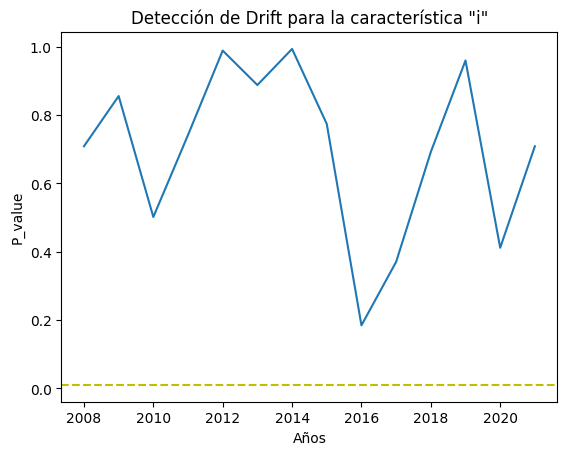

FEATURE  j


No se detectó drift en el año 2008 con un p-valor de [0.3701387]
No se detectó drift en el año 2009 con un p-valor de [0.1924815]
No se detectó drift en el año 2010 con un p-valor de [0.22329271]
No se detectó drift en el año 2011 con un p-valor de [0.1924815]
No se detectó drift en el año 2012 con un p-valor de [0.18033338]
No se detectó drift en el año 2013 con un p-valor de [0.62437415]
No se detectó drift en el año 2014 con un p-valor de [0.30162]
No se detectó drift en el año 2015 con un p-valor de [0.36352313]
Drift detectado en el año 2016 con un p-valor de [0.00417397]
No se detectó drift en el año 2017 con un p-valor de [0.63279337]
No se detectó drift en el año 2018 con un p-valor de [0.4114074]
No se detectó drift en el año 2019 con un p-valor de [0.2525621]
No se detectó drift en el año 2020 con un p-valor de [0.11135257]
Drift detectado en el año 2021 con un p-valor de [0.]


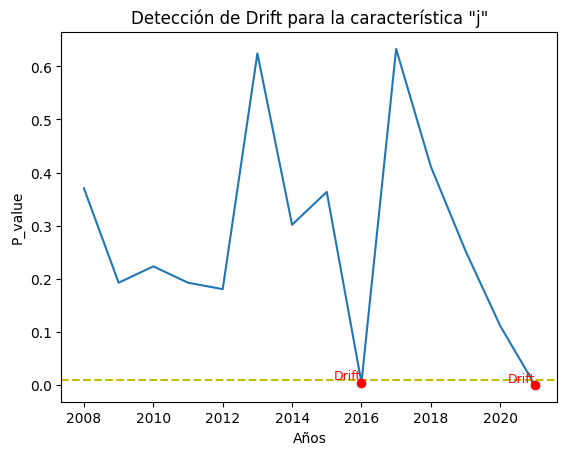

In [27]:
year = np.array(range(2008,2022))
features = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']


values_df = pd.DataFrame(columns = ["a", "b", "c", "d", "e", "f", "g", "h", "i", "j"])

for feat in range(len(features)):
    ks_drift = KSDrift(np.array(X_ref.iloc[:,feat]), p_val=0.01)
    
    print('FEATURE ', features[feat])
    print('\n')
    p_values = []
    
    for i, batch in enumerate(batch_generator(np.array(X_t0.iloc[:,feat]), 20000)):
        drift_detection = ks_drift.predict(batch)
        p_values.append(drift_detection['data']['p_val'])
        if drift_detection['data']['is_drift'] == 1:
            print(f"Drift detectado en el año {year[i]} con un p-valor de {drift_detection['data']['p_val']}")
        else:
            print(f"No se detectó drift en el año {year[i]} con un p-valor de {drift_detection['data']['p_val']}")
    values_df[features[feat]] = p_values
    plot_drift_detection(year, p_values, features[feat])


In [28]:
values_df = values_df.astype(float)


In [29]:
heatmap_data = values_df.transpose()

In [30]:
heatmap_data.columns = year

In [31]:
heatmap_data

,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
a,0.425747,0.666519,0.725074,0.390439,3.701387e-01,0.797171,0.200928,0.599207,0.683354,0.624374,0.893603,0.093886,0.848482,0.765778
b,0.462799,0.000000,0.284570,0.789442,1.725747e-01,0.797171,0.074849,0.641221,0.462799,0.921145,0.708473,0.418542,0.691750,0.252562
c,0.797171,0.011450,0.789442,0.176420,1.908308e-23,0.757749,0.390439,0.344137,0.218675,0.242505,0.295859,0.789442,0.910636,0.227984
d,0.725074,0.658089,0.252562,0.827145,0.000000e+00,0.819804,0.969034,0.411407,0.214130,0.848482,0.993307,0.279042,0.525292,0.781630
e,0.855348,0.834375,0.404345,0.242505,1.254051e-01,0.741513,0.848482,0.971846,0.325447,0.757749,0.765778,0.834375,0.582540,0.028704
f,0.131418,0.218675,0.599207,0.812357,8.271448e-01,0.411407,0.493591,0.541443,0.910636,0.757749,0.658089,0.525292,0.363523,0.804811
g,0.590860,0.301620,0.331599,0.749659,6.243742e-01,0.789442,0.887601,0.841489,0.470405,0.757749,0.812357,0.700124,0.344137,0.031312
h,0.541443,0.893603,0.599207,0.827145,7.001241e-01,0.834375,0.765778,0.641221,0.773740,0.741513,0.184314,0.000000,0.000000,0.000000
i,0.708473,0.855348,0.501436,0.741513,9.884275e-01,0.887601,0.993307,0.773740,0.184314,0.370139,0.691750,0.959529,0.411407,0.708473
j,0.370139,0.192482,0.223293,0.192482,1.803334e-01,0.624374,0.301620,0.363523,0.004174,0.632793,0.411407,0.252562,0.111353,0.000000


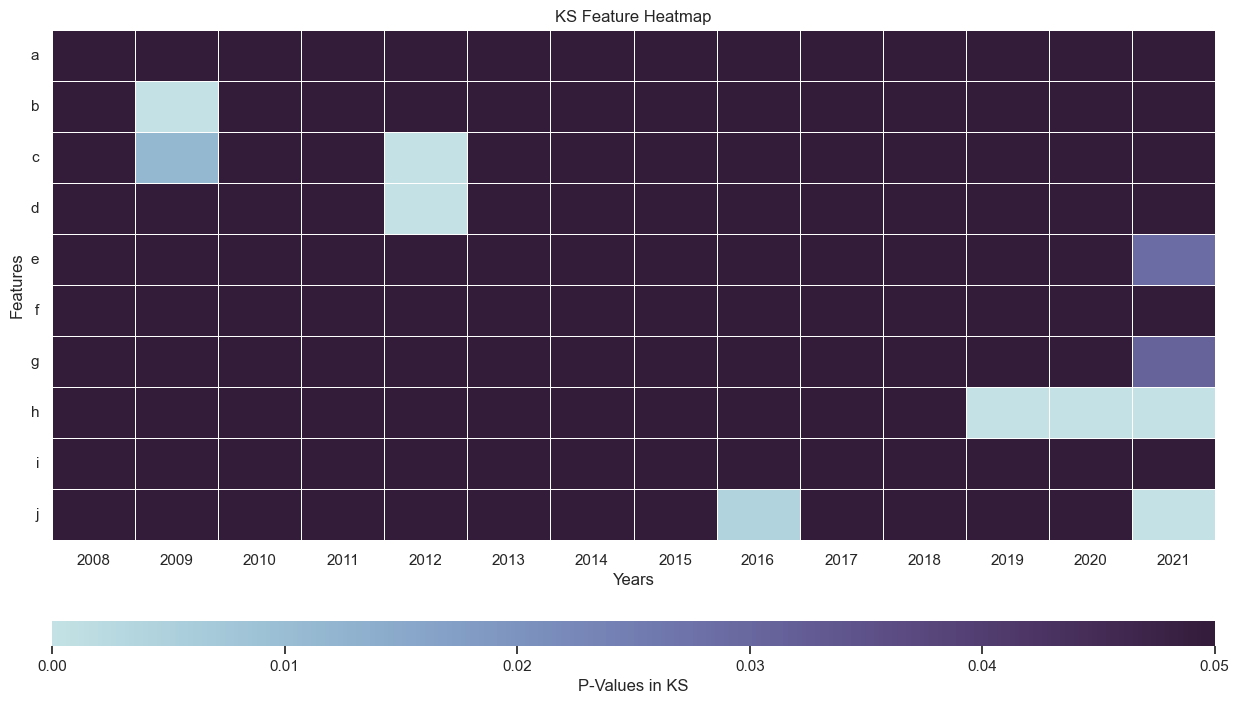

In [35]:
sns.set(rc={"figure.figsize": (15, 8)})
grid_kws = {"height_ratios": (20, 1), "hspace": 0.3}
f, (ax, cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws)
coloring = sns.cubehelix_palette(start = 0.5, rot = -0.4, as_cmap=True)
ax = sns.heatmap(
    heatmap_data,
    ax=ax,
    cmap=coloring,
    vmax = 0.05,
    xticklabels=heatmap_data.columns,
    yticklabels=heatmap_data.index,
    linewidths=0.5,
    cbar_ax=cbar_ax,
    cbar_kws={"orientation": "horizontal"},
)

ax.set_title('KS Feature Heatmap')
ax.set(xlabel="Years", ylabel="Features")
ax.collections[0].colorbar.set_label("P-Values in KS")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.show()

### Cramer-Von Mises (CVM)

No se detectó drift en el año 2008 con un p-valor de [0.58494055]
No se detectó drift en el año 2009 con un p-valor de [0.48784754]
No se detectó drift en el año 2010 con un p-valor de [0.61008]
No se detectó drift en el año 2011 con un p-valor de [0.20045803]
No se detectó drift en el año 2012 con un p-valor de [0.5266528]
No se detectó drift en el año 2013 con un p-valor de [0.74422127]
No se detectó drift en el año 2014 con un p-valor de [0.40900522]
No se detectó drift en el año 2015 con un p-valor de [0.6490667]
No se detectó drift en el año 2016 con un p-valor de [0.705965]
No se detectó drift en el año 2017 con un p-valor de [0.62700146]
No se detectó drift en el año 2018 con un p-valor de [0.8494572]
No se detectó drift en el año 2019 con un p-valor de [0.02836065]
No se detectó drift en el año 2020 con un p-valor de [0.6664657]
No se detectó drift en el año 2021 con un p-valor de [0.7088009]


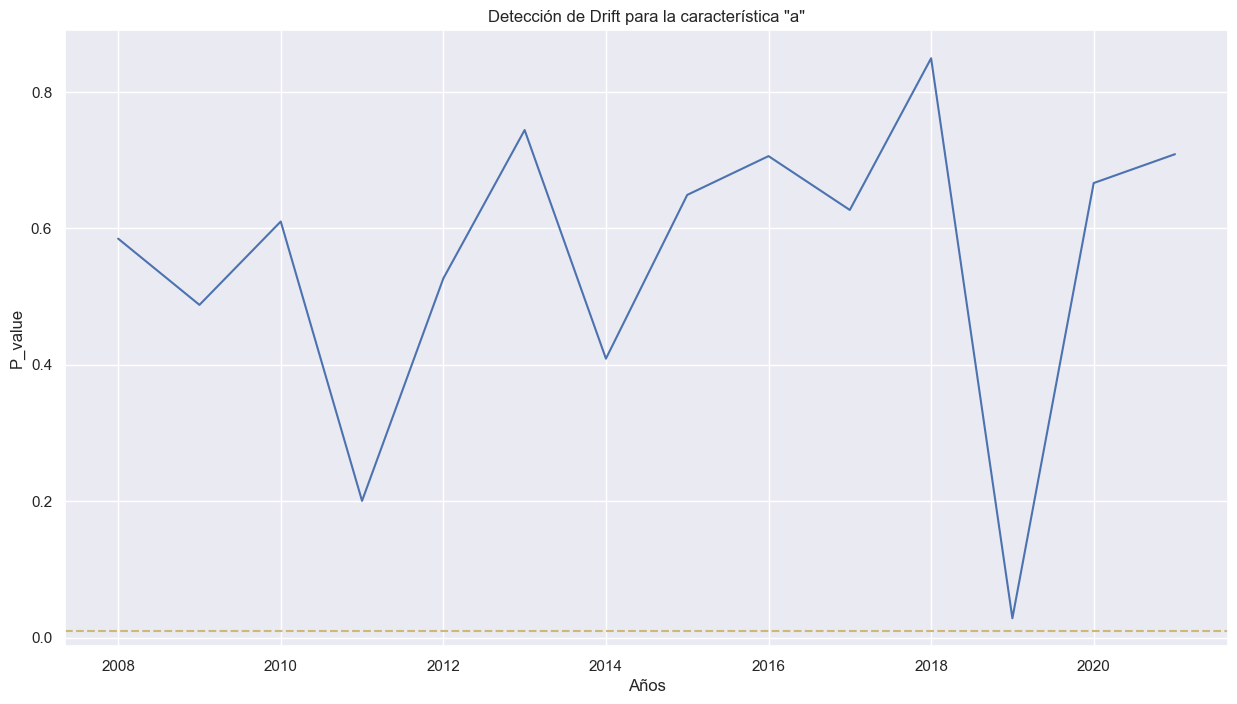

No se detectó drift en el año 2008 con un p-valor de [0.3687879]
Drift detectado en el año 2009 con un p-valor de [4.9274524e-07]
No se detectó drift en el año 2010 con un p-valor de [0.5030135]
No se detectó drift en el año 2011 con un p-valor de [0.9247172]
No se detectó drift en el año 2012 con un p-valor de [0.14762954]
No se detectó drift en el año 2013 con un p-valor de [0.5513002]
No se detectó drift en el año 2014 con un p-valor de [0.11063375]
No se detectó drift en el año 2015 con un p-valor de [0.44861796]
No se detectó drift en el año 2016 con un p-valor de [0.29646662]
No se detectó drift en el año 2017 con un p-valor de [0.95924294]
No se detectó drift en el año 2018 con un p-valor de [0.8613835]
No se detectó drift en el año 2019 con un p-valor de [0.23973593]
No se detectó drift en el año 2020 con un p-valor de [0.80904657]
No se detectó drift en el año 2021 con un p-valor de [0.2263604]


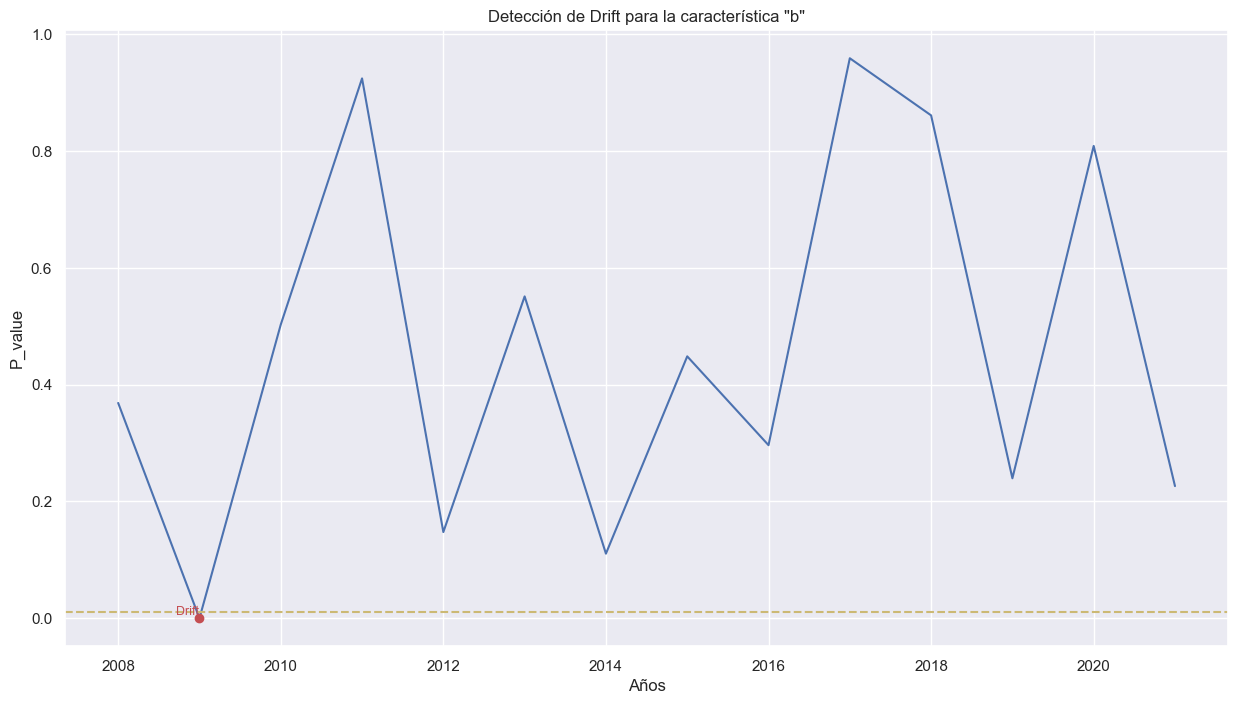

No se detectó drift en el año 2008 con un p-valor de [0.77995425]
No se detectó drift en el año 2009 con un p-valor de [0.02059289]
No se detectó drift en el año 2010 con un p-valor de [0.9713806]
No se detectó drift en el año 2011 con un p-valor de [0.23369992]
Drift detectado en el año 2012 con un p-valor de [6.08697e-10]
No se detectó drift en el año 2013 con un p-valor de [0.5858531]
No se detectó drift en el año 2014 con un p-valor de [0.33737838]
No se detectó drift en el año 2015 con un p-valor de [0.1843857]
No se detectó drift en el año 2016 con un p-valor de [0.18446326]
No se detectó drift en el año 2017 con un p-valor de [0.43160436]
No se detectó drift en el año 2018 con un p-valor de [0.29905507]
No se detectó drift en el año 2019 con un p-valor de [0.6269873]
No se detectó drift en el año 2020 con un p-valor de [0.87119704]
No se detectó drift en el año 2021 con un p-valor de [0.37959284]


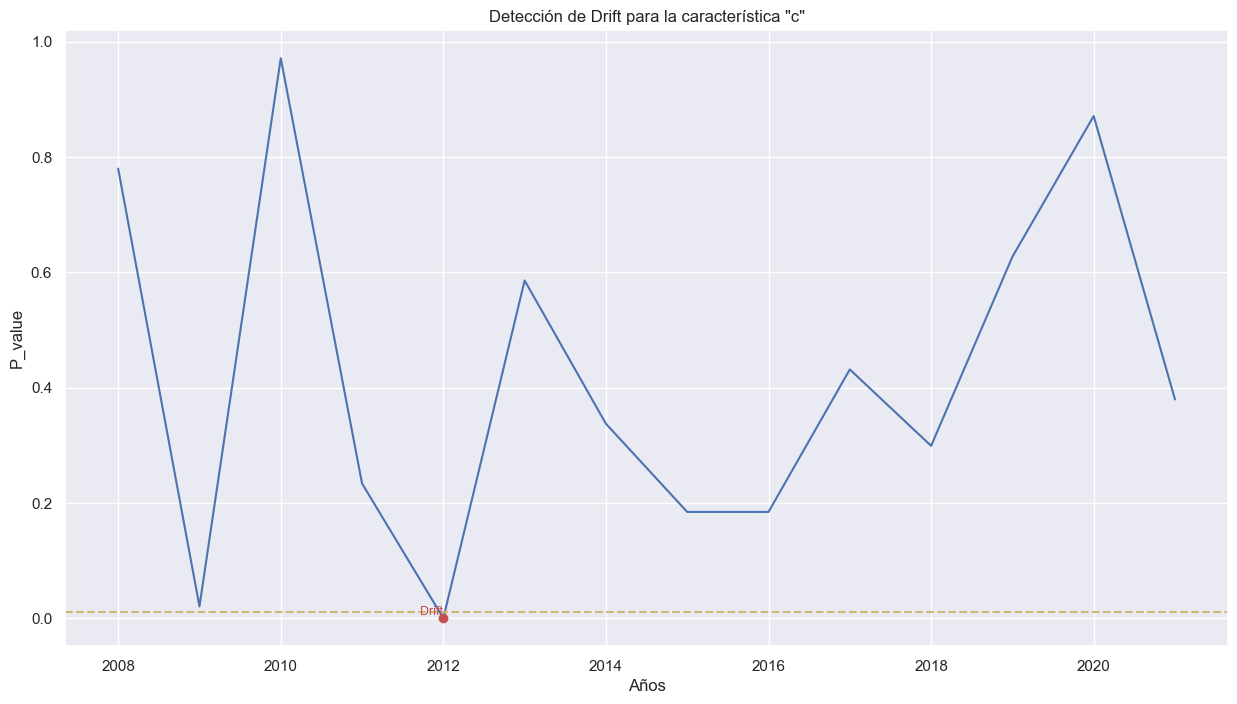

No se detectó drift en el año 2008 con un p-valor de [0.8650952]
No se detectó drift en el año 2009 con un p-valor de [0.68489474]
No se detectó drift en el año 2010 con un p-valor de [0.23680352]
No se detectó drift en el año 2011 con un p-valor de [0.86479354]
Drift detectado en el año 2012 con un p-valor de [8.8490594e-08]
No se detectó drift en el año 2013 con un p-valor de [0.91427684]
No se detectó drift en el año 2014 con un p-valor de [0.95782846]
No se detectó drift en el año 2015 con un p-valor de [0.5508394]
No se detectó drift en el año 2016 con un p-valor de [0.13827944]
No se detectó drift en el año 2017 con un p-valor de [0.81229496]
No se detectó drift en el año 2018 con un p-valor de [0.97610414]
No se detectó drift en el año 2019 con un p-valor de [0.14399193]
No se detectó drift en el año 2020 con un p-valor de [0.63569754]
No se detectó drift en el año 2021 con un p-valor de [0.8135917]


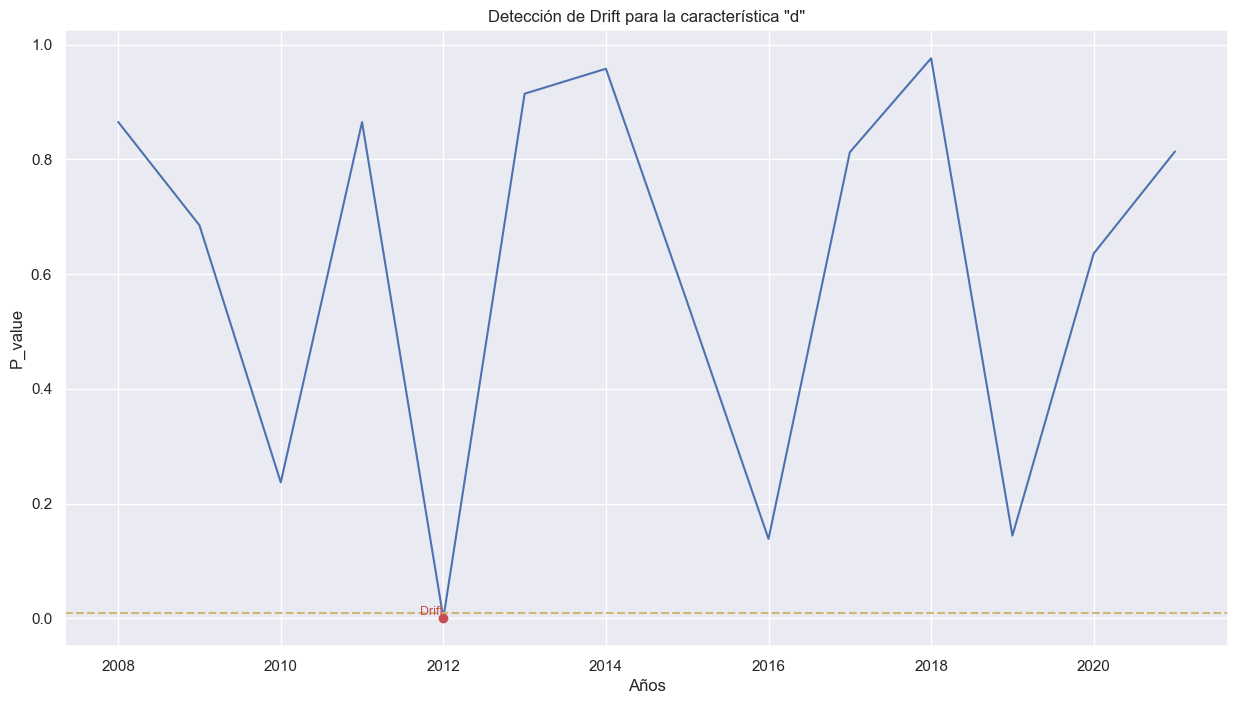

No se detectó drift en el año 2008 con un p-valor de [0.8826241]
No se detectó drift en el año 2009 con un p-valor de [0.76716346]
No se detectó drift en el año 2010 con un p-valor de [0.5529359]
No se detectó drift en el año 2011 con un p-valor de [0.21352911]
No se detectó drift en el año 2012 con un p-valor de [0.05736147]
No se detectó drift en el año 2013 con un p-valor de [0.8292849]
No se detectó drift en el año 2014 con un p-valor de [0.72735465]
No se detectó drift en el año 2015 con un p-valor de [0.97292393]
No se detectó drift en el año 2016 con un p-valor de [0.13482481]
No se detectó drift en el año 2017 con un p-valor de [0.8296423]
No se detectó drift en el año 2018 con un p-valor de [0.89487994]
No se detectó drift en el año 2019 con un p-valor de [0.79366493]
No se detectó drift en el año 2020 con un p-valor de [0.40403953]
No se detectó drift en el año 2021 con un p-valor de [0.09204073]


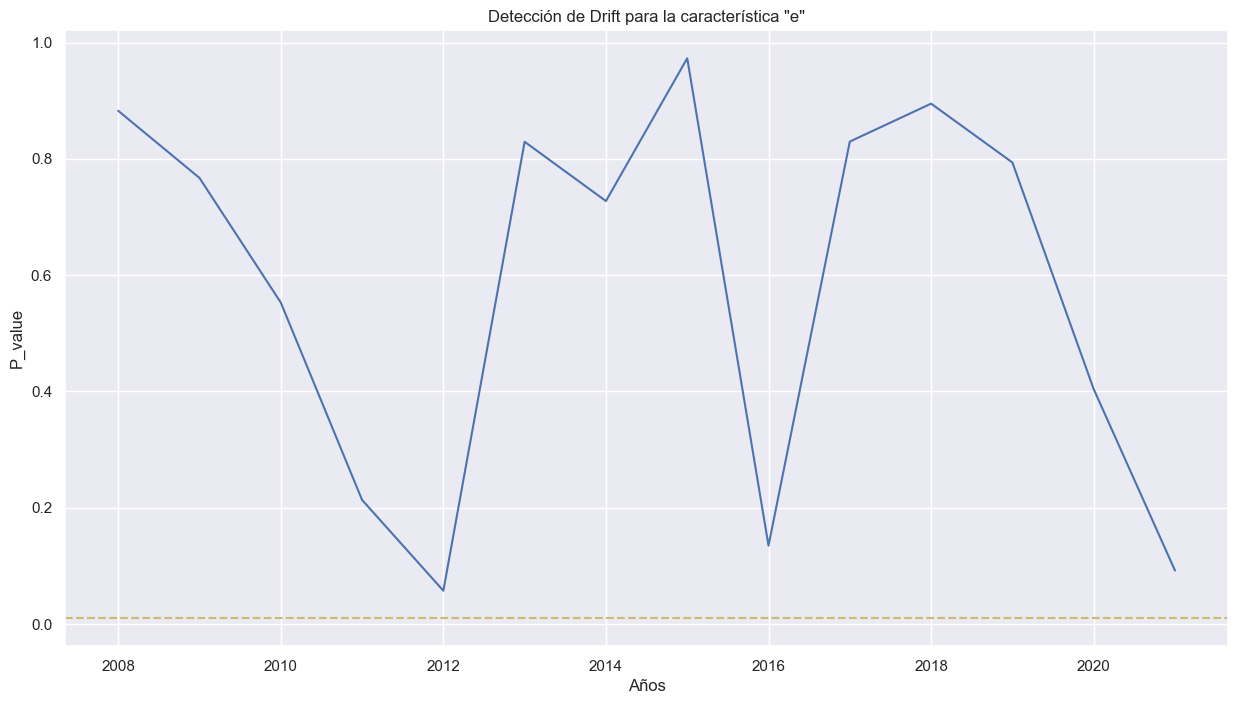

No se detectó drift en el año 2008 con un p-valor de [0.13112277]
No se detectó drift en el año 2009 con un p-valor de [0.18443461]
No se detectó drift en el año 2010 con un p-valor de [0.4794683]
No se detectó drift en el año 2011 con un p-valor de [0.75586516]
No se detectó drift en el año 2012 con un p-valor de [0.6931021]
No se detectó drift en el año 2013 con un p-valor de [0.39356273]
No se detectó drift en el año 2014 con un p-valor de [0.8836747]
No se detectó drift en el año 2015 con un p-valor de [0.35439503]
No se detectó drift en el año 2016 con un p-valor de [0.96007943]
No se detectó drift en el año 2017 con un p-valor de [0.7590335]
No se detectó drift en el año 2018 con un p-valor de [0.74772775]
No se detectó drift en el año 2019 con un p-valor de [0.5111607]
No se detectó drift en el año 2020 con un p-valor de [0.48090035]
No se detectó drift en el año 2021 con un p-valor de [0.6547924]


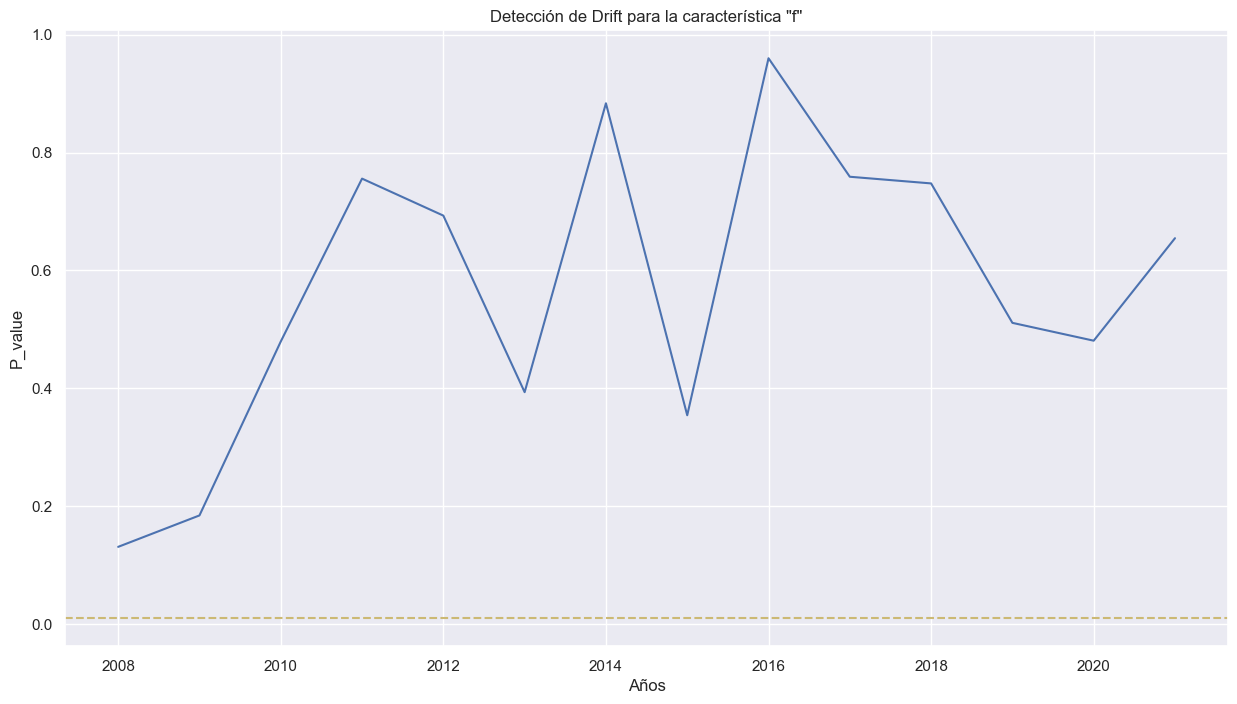

No se detectó drift en el año 2008 con un p-valor de [0.5391324]
No se detectó drift en el año 2009 con un p-valor de [0.24425836]
No se detectó drift en el año 2010 con un p-valor de [0.28692105]
No se detectó drift en el año 2011 con un p-valor de [0.6050243]
No se detectó drift en el año 2012 con un p-valor de [0.3778025]
No se detectó drift en el año 2013 con un p-valor de [0.67343974]
No se detectó drift en el año 2014 con un p-valor de [0.8719516]
No se detectó drift en el año 2015 con un p-valor de [0.8390998]
No se detectó drift en el año 2016 con un p-valor de [0.42043328]
No se detectó drift en el año 2017 con un p-valor de [0.86631274]
No se detectó drift en el año 2018 con un p-valor de [0.8276869]
No se detectó drift en el año 2019 con un p-valor de [0.63274723]
No se detectó drift en el año 2020 con un p-valor de [0.30686554]
No se detectó drift en el año 2021 con un p-valor de [0.02392081]


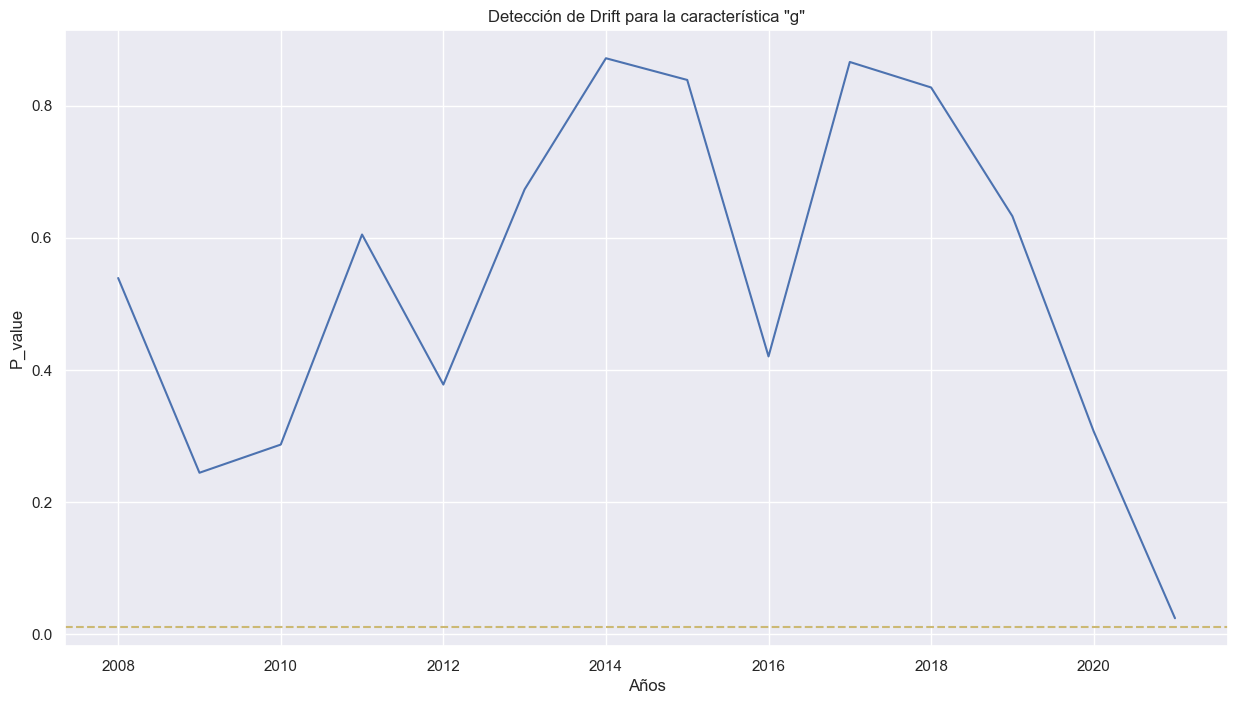

No se detectó drift en el año 2008 con un p-valor de [0.7176064]
No se detectó drift en el año 2009 con un p-valor de [0.9359555]
No se detectó drift en el año 2010 con un p-valor de [0.6433251]
No se detectó drift en el año 2011 con un p-valor de [0.64168954]
No se detectó drift en el año 2012 con un p-valor de [0.46367145]
No se detectó drift en el año 2013 con un p-valor de [0.6851939]
No se detectó drift en el año 2014 con un p-valor de [0.49363664]
No se detectó drift en el año 2015 con un p-valor de [0.65362144]
No se detectó drift en el año 2016 con un p-valor de [0.86100656]
No se detectó drift en el año 2017 con un p-valor de [0.7000038]
No se detectó drift en el año 2018 con un p-valor de [0.16862118]
Drift detectado en el año 2019 con un p-valor de [4.862051e-07]
Drift detectado en el año 2020 con un p-valor de [4.828636e-07]
Drift detectado en el año 2021 con un p-valor de [4.851183e-07]


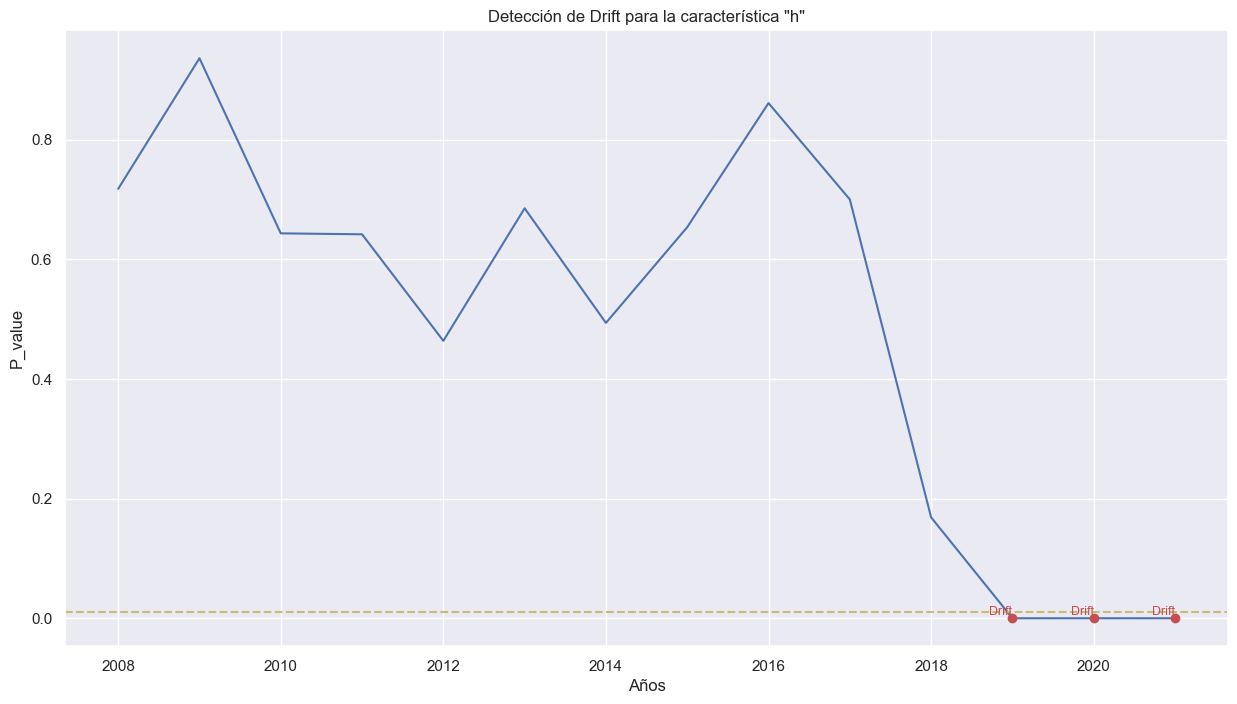

No se detectó drift en el año 2008 con un p-valor de [0.5896469]
No se detectó drift en el año 2009 con un p-valor de [0.9372366]
No se detectó drift en el año 2010 con un p-valor de [0.74386585]
No se detectó drift en el año 2011 con un p-valor de [0.5554256]
No se detectó drift en el año 2012 con un p-valor de [0.9890855]
No se detectó drift en el año 2013 con un p-valor de [0.77668804]
No se detectó drift en el año 2014 con un p-valor de [0.9917495]
No se detectó drift en el año 2015 con un p-valor de [0.6223078]
No se detectó drift en el año 2016 con un p-valor de [0.23918912]
No se detectó drift en el año 2017 con un p-valor de [0.21378586]
No se detectó drift en el año 2018 con un p-valor de [0.83509904]
No se detectó drift en el año 2019 con un p-valor de [0.9224824]
No se detectó drift en el año 2020 con un p-valor de [0.75975865]
No se detectó drift en el año 2021 con un p-valor de [0.6196761]


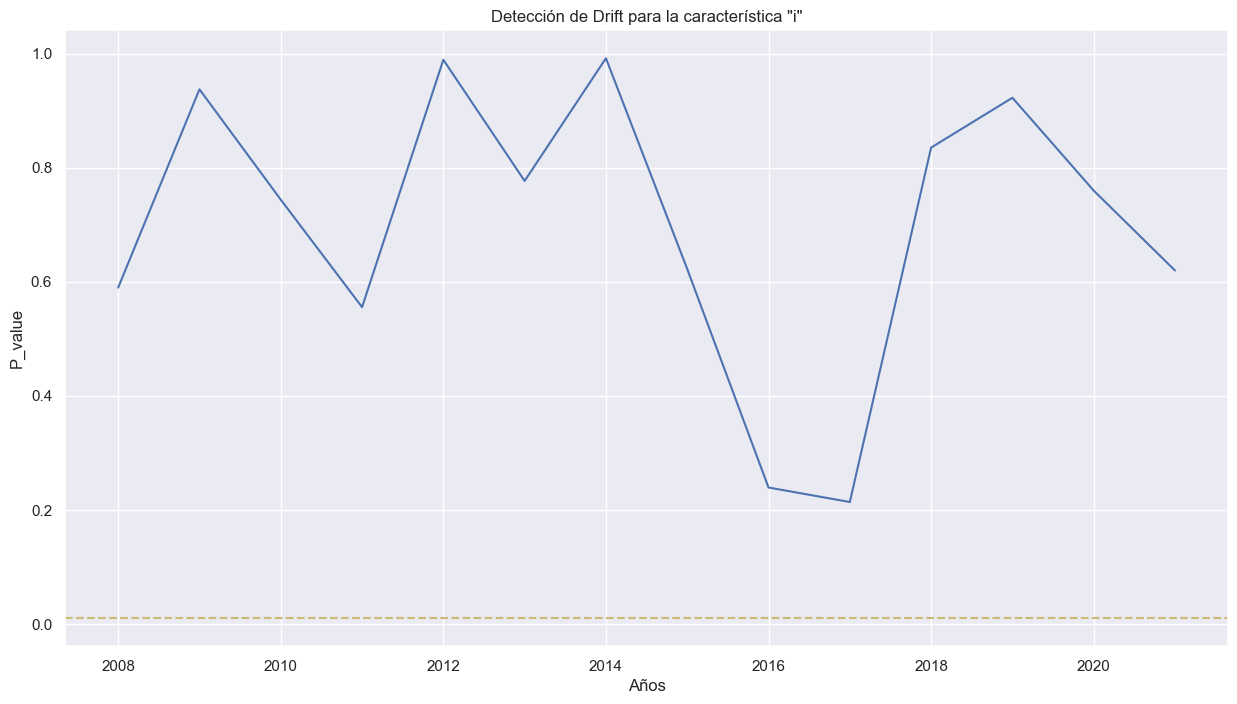

No se detectó drift en el año 2008 con un p-valor de [0.3613255]
No se detectó drift en el año 2009 con un p-valor de [0.28190166]
No se detectó drift en el año 2010 con un p-valor de [0.27519748]
No se detectó drift en el año 2011 con un p-valor de [0.2638412]
No se detectó drift en el año 2012 con un p-valor de [0.06910119]
No se detectó drift en el año 2013 con un p-valor de [0.59488344]
No se detectó drift en el año 2014 con un p-valor de [0.20416775]
No se detectó drift en el año 2015 con un p-valor de [0.33396506]
Drift detectado en el año 2016 con un p-valor de [0.00340995]
No se detectó drift en el año 2017 con un p-valor de [0.619259]
No se detectó drift en el año 2018 con un p-valor de [0.57756466]
No se detectó drift en el año 2019 con un p-valor de [0.2721255]
No se detectó drift en el año 2020 con un p-valor de [0.17533934]
Drift detectado en el año 2021 con un p-valor de [4.927253e-07]


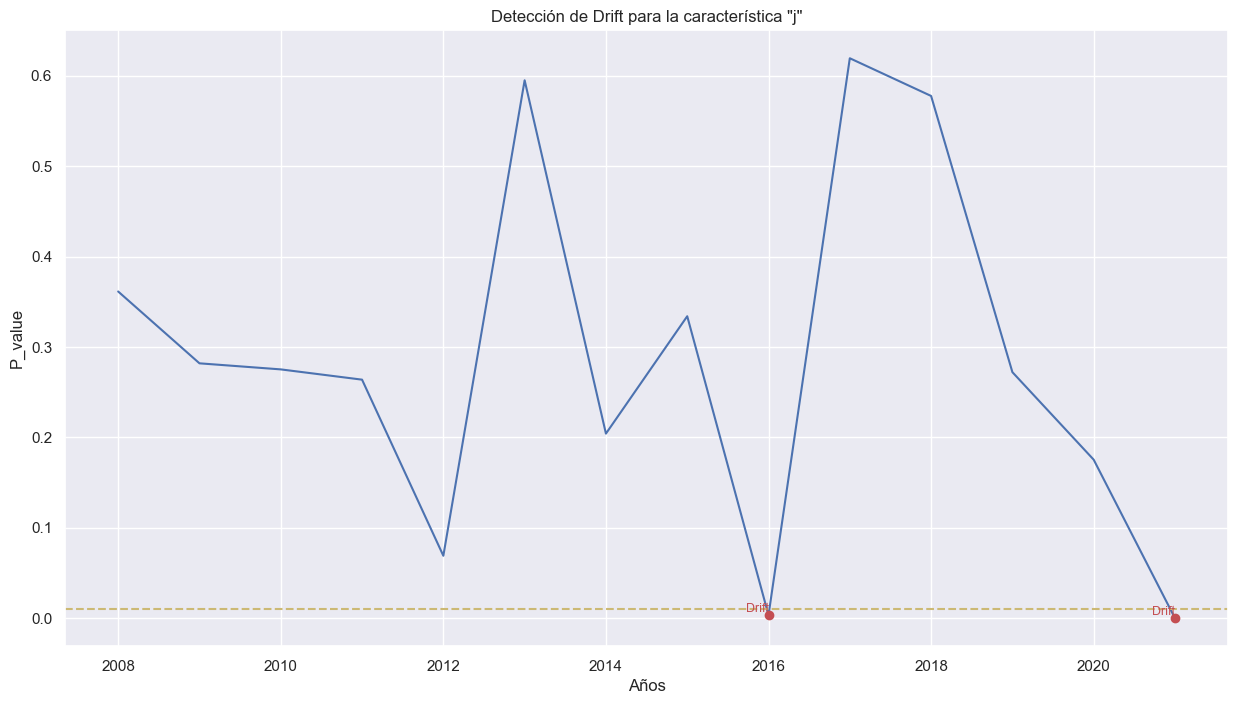

In [37]:
year = np.array(range(2008,2022))
features = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']
values_df = pd.DataFrame(columns = ["a", "b", "c", "d", "e", "f", "g", "h", "i", "j"])

for feat in range(len(features)):
    cvm_drift = CVMDrift(np.array(X_ref.iloc[:,feat]), p_val=0.01)
    
    
    p_values = []
    
    for i, batch in enumerate(batch_generator(np.array(X_t0.iloc[:,feat]), 20000)):
        drift_detection = cvm_drift.predict(batch)
        p_values.append(drift_detection['data']['p_val'])
        if drift_detection['data']['is_drift'] == 1:
            print(f"Drift detectado en el año {year[i]} con un p-valor de {drift_detection['data']['p_val']}")
        else:
            print(f"No se detectó drift en el año {year[i]} con un p-valor de {drift_detection['data']['p_val']}")
    values_df[features[feat]] = p_values
    plot_drift_detection(year, p_values, features[feat])

In [38]:
values_df = values_df.astype(float)

In [39]:
heatmap_data = values_df.transpose()

In [40]:
heatmap_data.columns = year

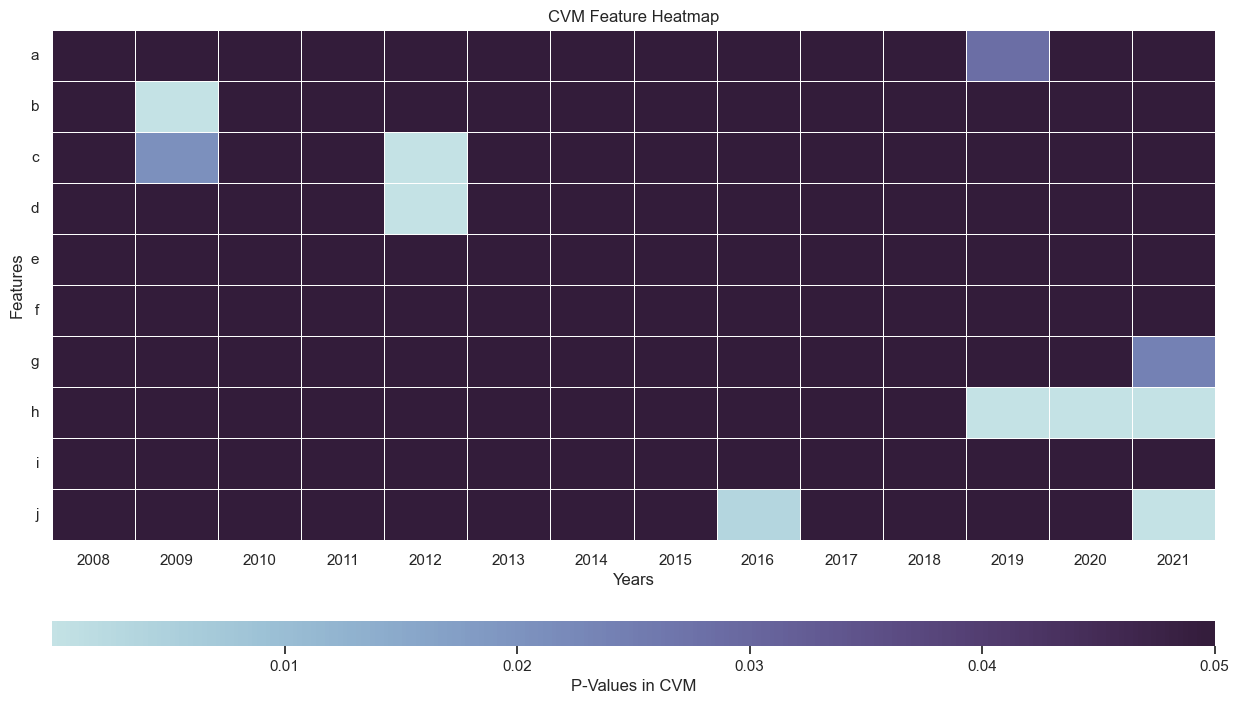

In [41]:
sns.set(rc={"figure.figsize": (15, 8)})
grid_kws = {"height_ratios": (20, 1), "hspace": 0.3}
f, (ax, cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws)
coloring = sns.cubehelix_palette(start = 0.5, rot = -0.4, as_cmap=True)
ax = sns.heatmap(
    heatmap_data,
    ax=ax,
    cmap=coloring,
    vmax = 0.05,
    xticklabels=heatmap_data.columns,
    yticklabels=heatmap_data.index,
    linewidths=0.5,
    cbar_ax=cbar_ax,
    cbar_kws={"orientation": "horizontal"},
)

ax.set_title('CVM Feature Heatmap')
ax.set(xlabel="Years", ylabel="Features")
ax.collections[0].colorbar.set_label("P-Values in CVM")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.show()

## Online

In [10]:
from alibi_detect.cd import MMDDriftOnline

In [11]:
n_ref = 20000

categorical_map = df.select_dtypes(include=['category']).columns.tolist()
X_ref, X_t0= df[:n_ref], df[n_ref:]



In [12]:
X_ref

,a,b,c,d,e,f,g,h,i,j
0,5036.441154,198.936685,6995.029198,133187.697950,0.402750,-1.339692,90453.457231,8819.761759,5398.861764,1059.835492
1,10773.027107,179.260652,3467.970499,52174.100900,1.019491,-1.145258,72629.507052,10137.233887,7009.344647,1552.888540
2,6173.596856,199.775829,4921.472906,101848.950792,-2.248839,1.903668,54839.516587,9603.709193,10579.518133,856.266082
3,13208.612929,182.222072,9638.632797,92442.165726,-0.045599,1.106212,84447.758390,12511.305427,5618.433039,451.926312
4,2719.272009,213.028454,5501.439179,79155.846985,-1.602719,-1.368130,168769.099013,16034.259622,6214.909756,853.582074
...,...,...,...,...,...,...,...,...,...,...
19995,5364.710821,208.382360,9746.552079,101526.208163,-0.698032,-0.881142,70916.529162,14062.450341,10971.969397,917.322988
19996,4483.465573,203.131806,6480.968712,139829.904270,0.027155,1.659847,100089.773534,9693.803736,12887.003253,1243.383758
19997,5422.838534,201.958562,17409.525027,81433.431760,-2.001971,1.796530,88055.279116,23136.862696,9352.747232,1294.432068
19998,13140.759011,192.956187,3374.866352,80084.265655,-1.575061,-0.347297,132191.130413,10319.941080,11238.232369,842.221964


In [13]:

X_ref_prueba = X_ref.iloc[:,1]
X_an_prueba  = X_t0.iloc[:,1]

window_size = 100
ert = 50

# Convertir la lista a un DataFrame de Pandas
X_ref_prueba_df = pd.DataFrame(X_ref_prueba)

# Luego, convierte el DataFrame a un tensor de TensorFlow
x_ref_prueba = tf.convert_to_tensor(X_ref_prueba_df.values, dtype=tf.float32)

# Convertir la lista a un array numpy
X_an_prueba = pd.DataFrame(X_an_prueba)
X_an_prueba = tf.convert_to_tensor(X_an_prueba.values, dtype=tf.float32)


cd = MMDDriftOnline(np.array(x_ref_prueba), ert, window_size, device = 'cpu')

for i in range(len(X_an_prueba)):
    preds = cd.predict(X_an_prueba[i], return_test_stat=True)
    if preds['data']['is_drift'] ==1:
        print('DRIFT')
    else:
        print('NO')


Generating permutations of kernel matrix..


Computing thresholds: 100%|██████████████████████████████████████████████████████████| 100/100 [02:52<00:00,  1.72s/it]


NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
DRIFT
DRIFT
DRIFT
DRIFT
NO
DRIFT
NO
NO
NO
NO
NO
NO
NO
DRIFT
NO
NO
NO
DRIFT
DRIFT
DRIFT
DRIFT
DRIFT
DRIFT
DRIFT
DRIFT
DRIFT
DRIFT
DRIFT
NO
DRIFT
DRIFT
DRIFT
DRIFT
DRIFT
DRIFT
DRIFT
DRIFT
DRIFT
DRIFT
DRIFT
DRIFT
DRIFT
DRIFT
NO
DRIFT
DRIFT
DRIFT
DRIFT
DRIFT
DRIFT
DRIFT
DRIFT
DRIFT
DRIFT
DRIFT
DRIFT
DRIFT
DRIFT
DRIFT
DRIFT
DRIFT
DRIFT
DRIFT
DRIFT
DRIFT
DRIFT
DRIFT
DRIFT
DRIFT
DRIFT
DRIFT
DRIFT
DRIFT
DRIFT
DRIFT
DRIFT
DRIFT
DRIFT
DRIFT
DRIFT
DRIFT
DRIFT
DRIFT
DRIFT
DRIFT
DRIFT
DRIFT
DRIFT
DRIFT
DRIFT
DRIFT
NO
DRIFT
NO
DRIFT
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO
N

KeyboardInterrupt: 